In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.signal

### Initializing constants

In [2]:
f0 = 60 # Hz
n = 3 # number of Areas
m = 3 # number of Governor-Turbines in each Area

# generator
D = np.array([0.015,  0.014, 0.015])   #, 0.016, 0.014, 0.014, 0.015, 0.016, 0.015])
H_in_sec = np.array([5.031, 6.051, 3.741])
H = H_in_sec#*f0/2 #[0.1677, 0.12, 0.2, 0.2017, 0.15, 0.196, 0.1247, 0.1667, 0.187])*f0/2

# turbine and governor 
Tt = np.array([0.4,  0.36, 0.42, 0.44, 0.32, 0.4, 0.3, 0.4, 0.41])
Tg = np.array([0.08, 0.06, 0.07, 0.06, 0.06, 0.08, 0.07, 0.07, 0.08])

# droop
R = np.array([3, 3, 3.3, 2.7273, 2.6667, 2.5, 2.8235, 3, 2.9412])
R_sys_recipr = np.zeros(n)
for i in range(n):
    R_sys_recipr[i] = np.sum(R[i*m:i*m+m])

# AGC
# alfa only if many Governor-Turibne in one Area, must sum to 1 in one Area
alpha = np.array([0.4, 0.4, 0.2, 0.6, 0, 0.4, 0, 0.5, 0.5]) #np.array([0.4, 0.4, 0.2, 0.6, 0.2, 0.2, 0.6, 0.2 ,0.2])
beta = np.zeros(n)
for i in range(n):
    beta[i] = D[i] + 1/R_sys_recipr[i]
#beta = np.array([10, 8, 9, 9.5, 8.6, 10.1, 9.2, 9.1, 8.9])


# tie lines, matrix
Tij = np.array([[   0,  0.2, 0.25],
                [ 0.2,    0, 0.12],
                [0.25, 0.12,    0]])

### Declaring matrices

In [3]:
A11 = np.zeros([n, 2, 2])
A12 = np.zeros([n, 2, m])
A13 = np.zeros([n, 2, m])
A21 = np.zeros([n, m, 2])
A22 = np.zeros([n, m, m])
A23 = np.zeros([n, m, m])
A31 = np.zeros([n, m, 2])
A32 = np.zeros([n, m, m])
A33 = np.zeros([n, m, m])
A = np.zeros([n, 2+2*m, 2+2*m])

B11 = np.zeros([n, 2, 2])
B12 = np.zeros([n, m, 2])
B13 = np.zeros([n, m, 2])
B1 = np.zeros([n, 2+2*m, 2])

B21 = np.zeros([n, 2, 1])
B22 = np.zeros([n, m, 1])
B23 = np.zeros([n, m, 1])
B2 = np.zeros([n, 2+2*m, 1])

B = np.zeros([n, 2+2*m, 3])

C = np.zeros([n, 2+2*m])

### Assigning submatrices

In [4]:
for i in range(n):
    sumTij = np.sum(Tij[i]) #- Tij[i][i] - don't need to do this because Tii is always 0
    Hi_inv = 1/(2*H[i])

    for j in range(m):
        A22[i, j, j] = -1/Tt[i*m+j]              # m x m diag
        A31[i, j] = [-1/(Tg[i*m+j]*R[i*m+j]), 0] # m x 2
        A33[i, j, j] = -1/Tg[i*m+j]              # m x m diag

        B23[i, j] = [alpha[i*m+j]/Tg[i*m+j]]      # m x 1

    ##########
    A11[i] = [[  -D[i]*Hi_inv, -Hi_inv], # 2 x 2
              [2*np.pi*sumTij,       0]]
    A12[i] = [[Hi_inv]*m,                # 2 x m
              [     0]*m]
    A13[i] = [[0]*m,                     # 2 x m
              [0]*m]
    A21[i] = np.transpose(A13[i])        # m x 2
    A23[i] = -A22[i]
    A32[i] = np.full([m, m], 0)          # m x m
    ##########
    B11[i] = [[-Hi_inv,        0], # 2 x 2
              [      0, -2*np.pi]]
    B12[i] = [[0, 0]]*m            # m x 2
    B13[i] = B12[i]
    ##########
    B21[i] = [[0],          # 2 x 1         
              [0]]
    B22[i] = [[0]]*m        # m x 1
    ##########
    C[i] = np.concatenate([[beta[i], 1], [0]*m, [0]*m]) # 1 x 2+m+m

### Assigning matrices

In [5]:
rowsA = [0, 0, 0,   2, 2, 2,   2+m, 2+m, 2+m]
colsA = [0, 2, 2+m, 0, 2, 2+m, 0,   2,   2+m]
rowsB1 = [0, 2, 2+m]; colsB1 = 0
rowsB2 = [0, 2, 2+m]; colsB2 = 0

#A[i] = [[A11[i], A12[i], A13[i]],
#        [A21[i], A22[i], A23[i]],
#        [A31[i], A32[i], A33[i]]]
A[:, rowsA[0]:rowsA[0]+A11.shape[1], colsA[0]:colsA[0]+A11.shape[2]] = A11
A[:, rowsA[1]:rowsA[1]+A12.shape[1], colsA[1]:colsA[1]+A12.shape[2]] = A12
A[:, rowsA[2]:rowsA[2]+A13.shape[1], colsA[2]:colsA[2]+A13.shape[2]] = A13
A[:, rowsA[3]:rowsA[3]+A21.shape[1], colsA[3]:colsA[3]+A21.shape[2]] = A21
A[:, rowsA[4]:rowsA[4]+A22.shape[1], colsA[4]:colsA[4]+A22.shape[2]] = A22
A[:, rowsA[5]:rowsA[5]+A23.shape[1], colsA[5]:colsA[5]+A23.shape[2]] = A23
A[:, rowsA[6]:rowsA[6]+A31.shape[1], colsA[6]:colsA[6]+A31.shape[2]] = A31
A[:, rowsA[7]:rowsA[7]+A32.shape[1], colsA[7]:colsA[7]+A32.shape[2]] = A32
A[:, rowsA[8]:rowsA[8]+A33.shape[1], colsA[8]:colsA[8]+A33.shape[2]] = A33

#B1[i] = [B11[i],
#         B12[i],
#         B13[i]]
B1[:, rowsB1[0]:rowsB1[0]+B11.shape[1], colsB1:colsB1+B11.shape[2]] = B11
B1[:, rowsB1[1]:rowsB1[1]+B12.shape[1], colsB1:colsB1+B12.shape[2]] = B12
B1[:, rowsB1[2]:rowsB1[2]+B13.shape[1], colsB1:colsB1+B13.shape[2]] = B13

#B2[i] = [B21[i],
#         B22[i],
#         B23[i]]
B2[:, rowsB2[0]:rowsB2[0]+B21.shape[1], colsB2:colsB2+B21.shape[2]] = B21
B2[:, rowsB2[1]:rowsB2[1]+B22.shape[1], colsB2:colsB2+B22.shape[2]] = B22
B2[:, rowsB2[2]:rowsB2[2]+B23.shape[1], colsB2:colsB2+B23.shape[2]] = B23

#B[i] = [B1[i], B2[i]]
B = np.concatenate([B1, B2], 2)

### Resulting continuous form matrices

In [6]:
with np.printoptions(precision=4, suppress=True):
    print(A[0])
    print(B1[0])
    print(B2[0])
    print(C[0])

[[ -0.0015  -0.0994   0.0994   0.0994   0.0994   0.       0.       0.    ]
 [  2.8274   0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.      -2.5      0.       0.       2.5     -0.      -0.    ]
 [  0.       0.       0.      -2.7778   0.      -0.       2.7778  -0.    ]
 [  0.       0.       0.       0.      -2.381   -0.      -0.       2.381 ]
 [ -4.1667   0.       0.       0.       0.     -12.5      0.       0.    ]
 [ -5.5556   0.       0.       0.       0.       0.     -16.6667   0.    ]
 [ -4.329    0.       0.       0.       0.       0.       0.     -14.2857]]
[[-0.0994  0.    ]
 [ 0.     -6.2832]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]
 [ 0.      0.    ]]
[[0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [5.    ]
 [6.6667]
 [2.8571]]
[0.1225 1.     0.     0.     0.     0.     0.     0.    ]


### Changing matrices from constant to discrete form

In [7]:
time_step = 0.01 # sec

Ad = np.zeros([n, 2+2*m, 2+2*m])
Bd = np.zeros([n, 2+2*m, 3])
Cd = np.zeros([n, 2+2*m])
Dd = np.zeros([n, 1])
dt = np.zeros([n, 1])

for i in range(n):
    Ad[i], Bd[i], Cd[i], Dd[i], dt[i] = scipy.signal.cont2discrete((A[i], B[i], C[i], 0), time_step, method='zoh')

B1d = Bd[:, :, 0:2]
B2d = Bd[:, :, 2:]

### Resulting discrete form matirces

In [8]:
with np.printoptions(precision=4, suppress=True):
    print(Ad[0])
    print(B1d[0])
    print(B2d[0])
    print(Cd[0])

[[ 1.     -0.001   0.001   0.001   0.001   0.      0.      0.    ]
 [ 0.0283  1.      0.      0.      0.      0.      0.      0.    ]
 [-0.0005  0.      0.9753 -0.     -0.      0.0232 -0.     -0.    ]
 [-0.0007  0.     -0.      0.9726 -0.     -0.      0.0252 -0.    ]
 [-0.0005  0.     -0.     -0.      0.9765 -0.     -0.      0.0219]
 [-0.0392  0.     -0.     -0.     -0.      0.8825 -0.     -0.    ]
 [-0.0512  0.     -0.     -0.     -0.     -0.      0.8465 -0.    ]
 [-0.0403  0.     -0.     -0.     -0.     -0.     -0.      0.8669]]
[[-0.001   0.    ]
 [-0.     -0.0628]
 [ 0.     -0.    ]
 [ 0.     -0.    ]
 [ 0.     -0.    ]
 [ 0.     -0.    ]
 [ 0.     -0.    ]
 [ 0.     -0.    ]]
[[0.    ]
 [0.    ]
 [0.0006]
 [0.0009]
 [0.0003]
 [0.047 ]
 [0.0614]
 [0.0266]]
[0.1225 1.     0.     0.     0.     0.     0.     0.    ]


### Declaring time, input and output vectors, initial conditions and inputs

In [9]:
# Defining time steps
sim_time = 100 # sec
indexes = np.arange(int(sim_time/time_step))
T = np.array(indexes*time_step, dtype=np.float64).tolist()

# Declare input and output vectors
x = np.zeros(shape=(len(T), n, 2+m+m)) # state vector
w = np.zeros(shape=(len(T), n, 2))     # load change and tie-lines change
u = np.zeros(shape=(len(T), n, 1))     # LFC controller output
y = np.zeros(shape=(len(T), n, 1))     # Area Control Error (ACE)


# Initial conditions
x0 = np.zeros(shape=(n, 2+2*m)) # n x 2+2*m
x[0] = x0

# Load change in time
data = pd.read_csv("DeltaP_L.csv", header=None).values
w[:, 0, 0] = data[0, 0:len(T)]
w[:, 1, 0] = np.ones(len(T))*0.1
w[:, 2, 0] = np.ones(len(T))*(-0.3)

### Defining LFC controller (PID controllers)

In [10]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint, dt):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.dt = dt
        self.prev_error = 0
        self.integral = 0

    def update(self, measured_value):
        error = self.setpoint - measured_value
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error

        control_signal = self.Kp*error + self.Ki*self.integral + self.Kd*derivative
        return control_signal

### Defining simulation and plotting functions

In [11]:
def simulating(LFC_controllers):
    for t in indexes[1:]:
        for i in range(n):
            w[t-1, i, 1] = np.sum(Tij[i]*x[t-1, :, 0]) # v_i calculation
            # w[t-1, i, 1] = np.sumTij[i]*np.concatenate(x[t-1, :, 0], real_inputs[t-1, :])
            # Additional entries in Tij for inputs from real areas
            x[t, i] = Ad[i] @ x[t-1, i] + B1d[i] @ w[t-1, i] + B2d[i] @ u[t-1, i]
            y[t-1, i] = Cd[i] @ x[t-1, i]
            u[t, i] = LFC_controllers[i].update(y[t-1, i]) # Delta P_Ci calculation


def plotting():
    legend = []
    types = ['solid', 'dashdot', 'dotted']
    plt.figure()
    for i in range(n):
        legend.append(f"Area{i+1}")
        plt.subplot(3, 1, 1)
        plt.title(f"Response for Areas")
        plt.plot(T, x[:, i, 0], linestyle=types[i])
        plt.xlim(T[0], T[-1])
        plt.ylabel(f"freq_{i+1}")
        plt.subplot(3, 1, 2)
        plt.plot(T, y[:, i], linestyle=types[i])
        plt.xlim(T[0], T[-1])
        plt.ylabel(f"ACE {i+1}")
        plt.subplot(3, 1, 3)
        plt.plot(T, u[:, i], linestyle=types[i])
        plt.xlim(T[0], T[-1])
        plt.ylabel(f"LFC {i+1}")
    plt.subplot(3, 1, 1)
    plt.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
    plt.legend(legend, loc="upper right")
    plt.show()

### Initializing LFC controllers, running simulation, and plotting results

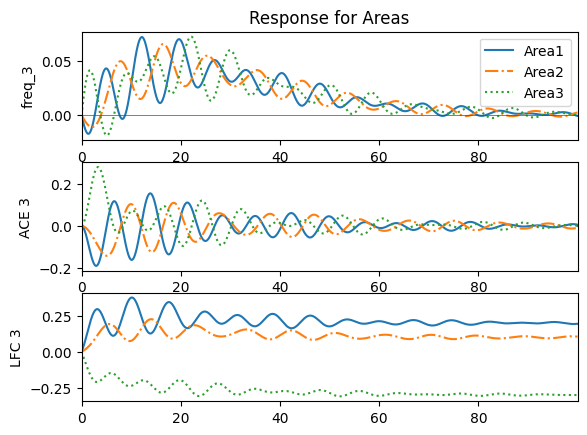

Final frequencies for each area:
Area 0: 59.9993 Hz
Area 1: 60.0024 Hz
Area 2: 59.9999 Hz


In [12]:
# LFC controllers parameters
K = np.array([[0.8, 0.5, 0.7],
              [0.6, 0.3, 0.7],
              [0.4, 0.2, 0.6]])

# Initializing LFC controllers
PID_controllers = []
for i in range(n):
    PID_controllers.append(
        PIDController(Kp=K[i, 0], Ki=K[i, 1], Kd=K[i, 2], setpoint=0, dt=dt[i]))
    
    
# Running simulation and plotting results
simulating(LFC_controllers=PID_controllers) 
plotting()

# Printing final results
print("Final frequencies for each area:")
for i in range(n):
    print(f"Area {i}: {round(x[-1, i, 0]+f0, 4)} Hz")